# <code><big>Machine Learning Assignment</big></code>
<br>
<br>
Author: Donatella Papa (donatella.papa86@gmail.com) <br>
Author: Matteo Giacalone (m.giacalone1@gmail.com)  
<code><br></code>
Last updated: 20th May 2016

# Outline
- [Introduction](#intro)
- [Obtaining and cleaning data](#data)
- [Classification Models](#class)
     - [Logistic Regression](#log)  
     - [Tree-Based Models](#tree)  
         - [Decision Trees](#dec)
         - [Bagging](#bag)
         - [AdaBoosting](#ada)
         - [Random Forest](#for)
         - [Gradient Boosting](#grad)
         - [Extreme Gradient Boosting](#ext)
     - [Support Vector Machine](#svm)
- [Conclusion](#conc)    
- [References](#ref)
 

# Introduction
<a id='intro'></a>
Satisfaction is a crucial concern for both customers and organisations, including banks. For the banks, the quality of service is crucial because they usually sell undifferentiated products. Among the main tools that banks can use to survive in the market is the judgment of their customers and their loyalty to the products and services. It is clear that banks have big interests in understanding the reason of the fidelization loss for their clients for building the basis of new strategies aimed at regaining this segment of customers. <br>
<br>
A multivariate analysis has been developed with the aim of extracting an optimal classification rule able to predict whether a client is a faithful customer or not.
The dataset under investigation is taken from the Santander Customer Satisfaction for the Kagglers competition. Our dataset contains 6016 entries relative to features of Santander customers. <br>
<br>
The variables stored for each entry will be discussed in the next section, underlying the existing of multicollinearities and constants.
The classification models will be described in the second section of this project. In addition, an attempt to introduce the best model to well fit the data will be showed.
In the third section, ROC curve will be explored, including the power of the aforementioned classification methods will be compared. 
To sum up, a discussion of the result will lead to the choice of the models that better fits this classification problem, including a comparison between the restricted (using cleaned data) and the full model (using all data).
   



### 0. Imports of libraries that allow the Python code to work 

In [2]:
from types import *
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from sklearn.cross_validation import train_test_split 
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# 1. Obtaining and cleaning data
<a id='data'></a>
The dataset contains 6016 entries, inizial composed of 270 variables. Each entry has a label (Target) indicating if the corresponding customer were satisfied or not. <br>
In order to apply the preliminar selection of features, the first observation is that many variables only have a few discrete values. <br>
Nearly 69% of all categorical variables have fewer than 3% valids case and it means that categorical variables are constant (and assume only a single entry). <br>
Furthermore, numerical values are heavily populated by 0s. <br>
We find that 99% of this categorical variables have more than 97% of their population filled by 0. <br>
These results suggest us that a large number of variables can be removed since they are constant or close to constant.

### Let's read our data in using pandas:


In [4]:
data = pd.read_csv("./dataset.csv", delimiter=';')


## Let's start our cleaning:

We isolate the Target and drop it (and ID) by the dataframe

In [5]:
# Last column in the dataframe is our Target, we stored it in a matrix
t = data.as_matrix(['TARGET'])
# Dropping from data of ID and Target
data.drop(["ID", "TARGET"],axis=1,inplace='TRUE')
#data.head()


- Remove the costant variables in the dataset (the variables that have 0 of standard deviation for rows)


In [4]:
eliminate = []

for l in  data.columns:
    if data[l].std() == 0.:
        eliminate.append(l)
        
data.drop(eliminate,axis=1,inplace='TRUE')

- We compute the correlation matrix in order to check the presents of collinearity

In [5]:
# correlation matrix 
corr = pd.DataFrame(data).corr() # Check the pairwise correlations of variables

#make indices for the collinear variables (m=columns and n=rows)
ind_vec_m = []
ind_vec_n = []
for m in corr:
    for n in corr:
        if (corr[m][n]>0.995 and corr[m][n] <1 and m > n):
            ind_vec_m.append(m)
            ind_vec_n.append(n)

- We create a list of unique variables 

In [6]:
#create a list of variables unique to remove from dataset
eliminate = []
eliminate = list(set(ind_vec_m))
data.drop(eliminate ,axis=1,inplace='TRUE')

eliminate = []
eliminate = list(set([x for x in ind_vec_n if ind_vec_n.count(x) > 1]))
data.drop(eliminate ,axis=1,inplace='TRUE')

- We remove the costant variables in the dataset, according to a fixed threshold

In [7]:
#remove the constant variables in the dataset (the variables that contain 
#less then 3% valid cases)
perc_const_values = 0.97
eliminate = []

for n in data.columns:
    summa = 0
    summa = data[data == 0 ].count()[n] 
    if summa > data.shape[0]*perc_const_values: #97% 
        eliminate.append(n)
        
data.drop(eliminate,axis=1,inplace='TRUE')



- We remove the costant variables in the dataset (above a threshold)

In [8]:
# remove the constant variables in the dataset (the variables that contain less 
#then 3% categorical variable with only one entry)
eliminate = []
for m in range(2,10):
    for n in data.columns:
        summa2 = 0
        summa2= summa = data[data == m ].count()[n]  
        if summa2 > data.shape[0]*perc_const_values: #97%
            eliminate.append(n)

data.drop(eliminate,axis=1,inplace='TRUE')
print ('The number of features after cleaning is %0.0f' % data.shape[1])

The number of features after cleaning is 103


# 2. Classification Models
<a id='class'></a>

Different models were explored. Given the high dimensionality of the problem, it is worth to give an attempt to a selection of the input variables. <br>
The feature importances, in the Tree-Based Model, will be applied for this porpuse.     
Given the presence of a categorical variable (dummies) and of a variable with six levels (like nun_var4) we decided not to perform discriminant analysis, given the non gaussianity of these variables.


### Split into training and test dataset

It is a typical procedure for machine learning and pattern classification tasks to split one dataset into two: a training dataset and a test dataset.
The training dataset is henceforth used to train our algorithms or classifier, and the test dataset is a way to validate the outcome quite objectively before we apply it to "new, real world data".

Here, we will split the dataset randomly so that 77% of the total dataset will become our training dataset, and 33% will become our test dataset, respectively.

In [18]:
# training and test set for the classification
X_train, X_test, y_train, y_test = train_test_split(data, t, 
                                                    test_size=0.33, random_state=50)
               

## Logistic Regression
<a id='log'></a>

Logistic regression is a regression model that is popularly used for classification tasks. In logistic regression, the probability that a binary target is True is modeled as a logistic function of a linear combination of features [1].
Starting from the 103 variables selected in previous analysis, we first apply the logistic regression (in the following indicated as LG) with categorical variable split in two levels simply specified by the logit: <br>

$
{logit (p) = log(p/(1-p))}
$


In [19]:
clf_lg = LogisticRegression()
classifier_lg = clf_lg.fit(X_train, y_train.ravel())

#Confusion matrix for the prediction 
predicted_lg = classifier_lg.predict(X_test)
cf_test_lg = mt.confusion_matrix(y_test.ravel(), predicted_lg)
print 'Confusion Matrix'
print cf_test_lg
print ('Precision = %0.4f' % mt.precision_score(y_test.ravel(), predicted_lg))
print ('Recall = %0.4f' % mt.recall_score(y_test.ravel(), predicted_lg))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test.ravel(), predicted_lg))

Confusion Matrix
[[616 402]
 [282 686]]
Precision = 0.6305
Recall = 0.7087
Accuracy = 0.6556


We check the performance of different regularization parameters for finding the best C (inverse of regularization strength) and improve the accuracy of the fit.

In [20]:
# As Regularization parameter: L1
best_coeff_L1, best_meas = 0,0
for i in np.logspace(-3,3,20):
    classifier_lg.set_params(penalty='l1', C=i)
    classifier_lg.fit(X_train, y_train.ravel())
    predicted_lg = classifier_lg.predict(X_test)
    acc = mt.accuracy_score(y_test.ravel(),predicted_lg)
    if acc > best_meas:
        best_meas = acc
        best_coeff_L1 = i
    print ('C = %5.3f; Accuracy = %0.4f'% (i, acc))
print("Best accuracy = %0.4f for i = %5.3f" % (best_meas, best_coeff_L1))

C = 0.001; Accuracy = 0.6561
C = 0.002; Accuracy = 0.7019
C = 0.004; Accuracy = 0.7044
C = 0.009; Accuracy = 0.7069
C = 0.018; Accuracy = 0.7064
C = 0.038; Accuracy = 0.7039
C = 0.078; Accuracy = 0.7024
C = 0.162; Accuracy = 0.7085
C = 0.336; Accuracy = 0.7085
C = 0.695; Accuracy = 0.7100
C = 1.438; Accuracy = 0.7120
C = 2.976; Accuracy = 0.7120
C = 6.158; Accuracy = 0.7130
C = 12.743; Accuracy = 0.7135
C = 26.367; Accuracy = 0.7135
C = 54.556; Accuracy = 0.7135
C = 112.884; Accuracy = 0.7135
C = 233.572; Accuracy = 0.7135
C = 483.293; Accuracy = 0.7135
C = 1000.000; Accuracy = 0.7140
Best accuracy = 0.7140 for i = 1000.000


In [25]:
# Regularization parameter = L2
best_coeff_L2, best_meas = 0,0
for i in np.logspace(-3,3,20):
    classifier_lg.set_params(penalty='l2', C=i)
    classifier_lg.fit(X_train, y_train.ravel())
    predicted_lg = classifier_lg.predict(X_test)
    acc = mt.accuracy_score(y_test.ravel(),predicted_lg)
    if acc > best_meas:
        best_meas = acc
        best_coeff_L2 = i
    print ('C = %5.3f; Accuracy = %0.4f'% (i, acc))
print("Best accuracy = %0.4f for i = %5.3f" % (best_meas, best_coeff_L2))

C = 0.001; Accuracy = 0.6636
C = 0.002; Accuracy = 0.6631
C = 0.004; Accuracy = 0.6823
C = 0.009; Accuracy = 0.6662
C = 0.018; Accuracy = 0.6561
C = 0.038; Accuracy = 0.6526
C = 0.078; Accuracy = 0.6571
C = 0.162; Accuracy = 0.6662
C = 0.336; Accuracy = 0.6657
C = 0.695; Accuracy = 0.6687
C = 1.438; Accuracy = 0.6556
C = 2.976; Accuracy = 0.6657
C = 6.158; Accuracy = 0.6551
C = 12.743; Accuracy = 0.6551
C = 26.367; Accuracy = 0.6576
C = 54.556; Accuracy = 0.6636
C = 112.884; Accuracy = 0.6722
C = 233.572; Accuracy = 0.6626
C = 483.293; Accuracy = 0.6647
C = 1000.000; Accuracy = 0.6591
Best accuracy = 0.6823 for i = 0.004


The underlying C implementation uses a random number generator to select features when fitting the model. It is thus not uncommon, to have slightly different results for the same input data. <br>
Then we applied again the LG using as penalty, L2 and as C, the best coefficents founded.

In [21]:
# Train the logistic model using the training sets 
classifier_lg.set_params(penalty='l1', C=best_coeff_L1)
classifier_lg = classifier_lg.fit(X_train, y_train.ravel())

#Confusion matrix for the prediction 
predicted_lg = classifier_lg.predict(X_test)
cf_test_lg = mt.confusion_matrix(y_test.ravel().ravel(), predicted_lg)
print 'Confusion Matrix'
print  cf_test_lg
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_lg))
print ('Recall = %0.4f' % mt.recall_score(y_test.ravel(), predicted_lg))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test.ravel(), predicted_lg))


Confusion Matrix
[[695 323]
 [246 722]]
Precision = 0.6909
Recall = 0.7459
Accuracy = 0.7135


To sum up, we observed the best model for the LG classifier with an increasing of the performance using L1 as parameter regularization.


## Tree-Based Models
<a id='tree'></a>

Decision tree-based models use a decision tree as a predictive model which maps observations about an item to conclusions about the item's target value.
Tree models where the target variable can take a finite set of values are called classification trees.
In the following analysis, we have used the same variables for the LG problem of customer target, chosen as explained before. 

### Decision Trees
<a id='dec'></a>

In this subsection, we used for our analysis Decision Tree models, that are powerful methods for classification problems. In particular, the LG will work for classification problems where classes are approximately linearly separable. Here, lets see how decision trees handle these problems. 
We know that decision trees are made of hierarchical one variable rules. 

In [22]:
#Decision Tree object                              
clf_tree = DecisionTreeClassifier(max_depth=5, 
                                  min_samples_split=1, 
                                  random_state=0)

# Train the model using the training sets 
classifier_tr = clf_tree.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_tr = clf_tree.predict(X_test) 

#Confusion matrix for the prediction
cf_test_tr = mt.confusion_matrix(y_test.ravel(), predicted_tr)
print 'Confusion Matrix'
print cf_test_tr
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_tr))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_tr))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_tr))


Confusion Matrix
[[704 314]
 [205 763]]
Precision = 0.7084
Recall = 0.7882
Accuracy = 0.7387


As we look before in the confusion matrix, the decision trees increase the accuracy of the classification. The different results for regression and decision trees depend to the differente variance-bias tradeoff. Indeed, in general, the regression models have high bias (“underfits” the data) and low variance, while the tree-based models have low bias (“overfits” the data) and high variance.  

### Bagging
<a id='bag'></a>

Bagging methods form a class of algorithms which build several instances of a estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it [2].

In [23]:
#Bagging object with KNeighbors boundary                     
clf_bg = BaggingClassifier(KNeighborsClassifier(),
                                  max_samples=0.5, max_features=0.5)

# Train the model using the training sets 
classifier_bg = clf_bg.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_bg = classifier_bg.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_bg = mt.confusion_matrix(y_test.ravel(), predicted_bg)
print 'Confusion Matrix'
print cf_test_bg
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_bg))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_bg))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_bg))

Confusion Matrix
[[642 376]
 [296 672]]
Precision = 0.6412
Recall = 0.6942
Accuracy = 0.6616


The fundamental parameters to tune when using the bagging methods is n_estimators and max_features. In scikit-learn, bagging methods are offered taking as input a base estimator. In details, max_samples and max_features control the size of the subsets, while bootstrap and bootstrap_features control whether samples and features are drawn with or without replacement. <br>
As we look below, the code illustrates how to create a bagging ensemble of KNeighborsClassifier base estimators, each built on random subsets of 50% of the samples and 50% of the features.

In [27]:
# As regularization of KNeighbors
best_coeff_bg, best_meas = 0,0
clf_bg = BaggingClassifier(KNeighborsClassifier(),
                                  max_samples=0.5, max_features=0.5)
for i in range(20,80,5):
    clf_bg.set_params(n_estimators=i)
    m = cross_val_score(clf_bg, X_train, y_train.ravel(), scoring='accuracy',cv=5).mean()
    if m > best_meas:
        best_coeff_bg = i
        best_meas = m
    print("n= %i: %0.4f" % (i, m))
print("Best accuracy = %0.4f for n = %i" % (best_meas, best_coeff_bg))

n= 20: 0.7161
n= 25: 0.7216
n= 30: 0.7228
n= 35: 0.7248
n= 40: 0.7186
n= 45: 0.7303
n= 50: 0.7179
n= 55: 0.7189
n= 60: 0.7164
n= 65: 0.7283
n= 70: 0.7345
n= 75: 0.7231
Best accuracy = 0.7345 for n = 70


In [29]:
# Train the model using the new estimators 
clf_bg = BaggingClassifier(KNeighborsClassifier(),n_estimators=best_coeff_bg, max_samples=0.5, 
                           max_features=0.5)
classifier_bg = clf_bg.fit(X_train, y_train.ravel())
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='accuracy',cv=5).mean()

#Confusion matrix 
print 'Confusion Matrix'
print cf_test_bg
print("Accuracy: %0.4f" % m)
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='precision',cv=5).mean()
print("Precision: %0.4f" % m)
m = cross_val_score(clf_bg, X_test, y_test.ravel(), scoring='recall',cv=5).mean()
print("Recall: %0.4f" % m)

Confusion Matrix
[[642 376]
 [296 672]]
Accuracy: 0.7145
Precision: 0.7093
Recall: 0.6828


### Adaptive Boosting
<a id='ada'></a>

AdaBoost is a machine learning meta-algorithm and it can be used together with several learning algorithms to improve their performance. The output of the weak learners is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive as the subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers.
We have implemented an AdaBoost classifier using the scikit library.

In [30]:
# Build a AdaBoosting object
clf_adaB = AdaBoostClassifier(n_estimators=35)

# Train the model using the training sets 
classifier_adaB = clf_adaB.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_adaB = clf_adaB.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_adaB = mt.confusion_matrix(y_test.ravel(), predicted_adaB)
print 'Confusion Matrix'
print cf_test_adaB
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_adaB))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_adaB))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_adaB))

Confusion Matrix
[[774 244]
 [254 714]]
Precision = 0.7453
Recall = 0.7376
Accuracy = 0.7492


 The accuracy and precision are not so high and demostrate that the AdaBoost is highly sensitive to noisy data and outliers and is susceptible to the overfitting problem.

### Random Forest
<a id='for'></a>
In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the tree building, the split that is chosen is no longer the best split among all features. As a result of this randomness, the bias of the forest usually slightly increases but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model. <br>
With a random forest, the first parameter to select is the number of trees because a large amount of trees serves to reduce variance. Each tree fits, or overfits, a part of the training set, and in the end their errors cancel out. We have tuned this parameter in order to improve the fit. <br>
We have looked also other parameters above all that ones that control how the big grow.

In [31]:
# Build a Random forest object
clf_forest = RandomForestClassifier(n_estimators=2000, # numbers of tree in the forest
                                    criterion='gini',
                                    max_depth=None,
                                    class_weight='balanced',
                                    min_samples_split=1,
                                    random_state=0)

# Train the random forest model using the training sets 
classifier_rf = clf_forest.fit(X_train, y_train.ravel())

Here, we assess the variable importances in the random forest. This technique gives a ranking respect to the importance of the target variable. Features used at the top of the tree are used contribute to the final prediction decision of a larger fraction of the input samples. 

In [32]:
# Take the random forest fit and compute the feature importances
importances_rf = clf_forest.feature_importances_
std_rf = np.std([tree.feature_importances_ for tree in clf_forest.estimators_],
             axis=0)
indices_rf = np.argsort(importances_rf)[::-1]

In [33]:
# Print the feature ranking: look at this and make the first interpretation

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_rf[f], importances_rf[indices_rf[f]]))

Feature ranking:
1. feature 0 (0.200571)
2. feature 102 (0.191151)
3. feature 97 (0.044991)
4. feature 95 (0.042184)
5. feature 60 (0.040059)
6. feature 62 (0.029897)
7. feature 96 (0.028054)
8. feature 94 (0.026342)
9. feature 55 (0.023459)
10. feature 92 (0.023397)
11. feature 91 (0.017149)
12. feature 76 (0.016897)
13. feature 79 (0.016190)
14. feature 63 (0.013045)
15. feature 78 (0.012726)
16. feature 93 (0.012319)
17. feature 30 (0.012185)
18. feature 46 (0.011515)
19. feature 47 (0.011134)
20. feature 24 (0.010479)
21. feature 74 (0.010196)
22. feature 82 (0.010164)
23. feature 73 (0.008826)
24. feature 75 (0.007583)
25. feature 7 (0.007517)
26. feature 8 (0.007175)
27. feature 6 (0.006758)
28. feature 54 (0.005809)
29. feature 44 (0.005719)
30. feature 10 (0.005514)
31. feature 77 (0.005493)
32. feature 5 (0.004853)
33. feature 3 (0.004682)
34. feature 65 (0.004546)
35. feature 45 (0.004405)
36. feature 88 (0.004172)
37. feature 86 (0.004074)
38. feature 84 (0.003920)
39. featu

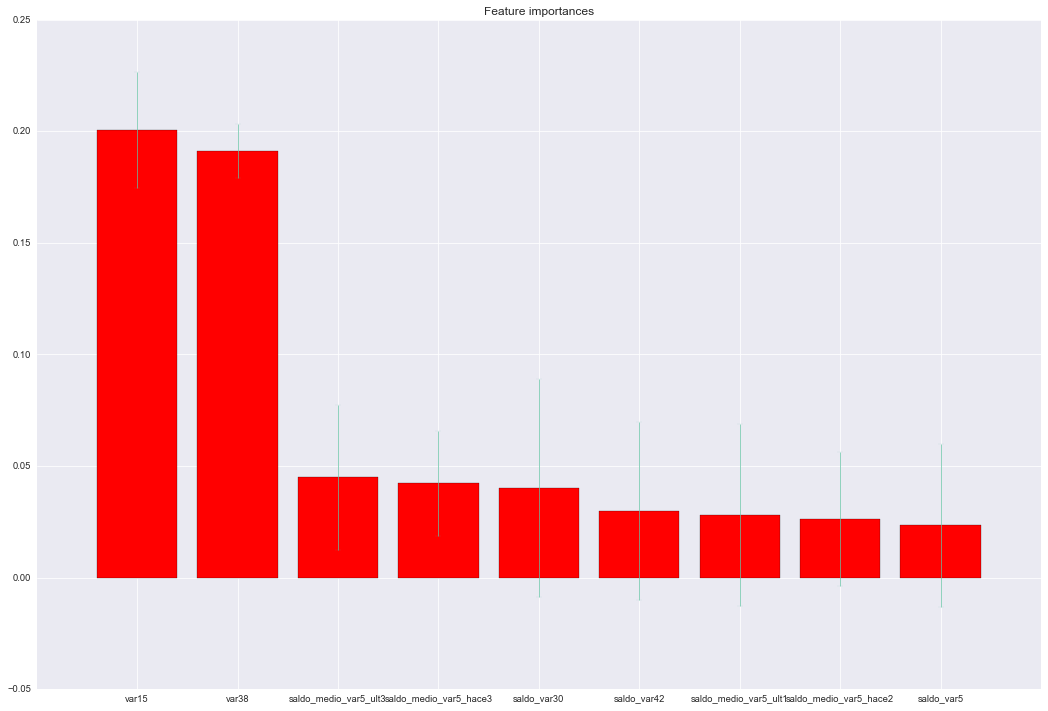

In [34]:
# Plot the feature importances of the forest
#colors = sns.color_palette("cubehelix", 4)
colors= sns.color_palette("Set2", 10)
sns.set(style="darkgrid", context='paper', palette=colors,
		rc={"figure.figsize": (16, 8), 'image.cmap': 'jet', 'lines.linewidth': .7})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
almost_black = '#262626'
indices_rf_restr = np.argsort(importances_rf)[:93:-1]
labels = []
for l in data.columns[indices_rf_restr]:
    labels.append(l)
plt.figure(figsize=(18,12))
plt.title("Feature importances", fontsize=12)
plt.bar(range(indices_rf_restr.shape[0]), importances_rf[indices_rf_restr],
       color="r", yerr=std_rf[indices_rf_restr], align="center")
plt.xticks(range(indices_rf_restr.shape[0]), labels, fontsize=9.4)
plt.yticks(fontsize=9.4)
plt.xlim([-1, indices_rf_restr.shape[0]])
plt.show()

The most important feature for Random Forrest is var15.
In addition, we have tried to explore this features in order to understand if there is a readable meaning.

In [35]:
X_train['var15'].describe()

count    4030.000000
mean       36.437965
std        13.036196
min         5.000000
25%        25.000000
50%        34.000000
75%        44.000000
max       105.000000
Name: var15, dtype: float64

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.]),
 <a list of 8 Text yticklabel objects>)

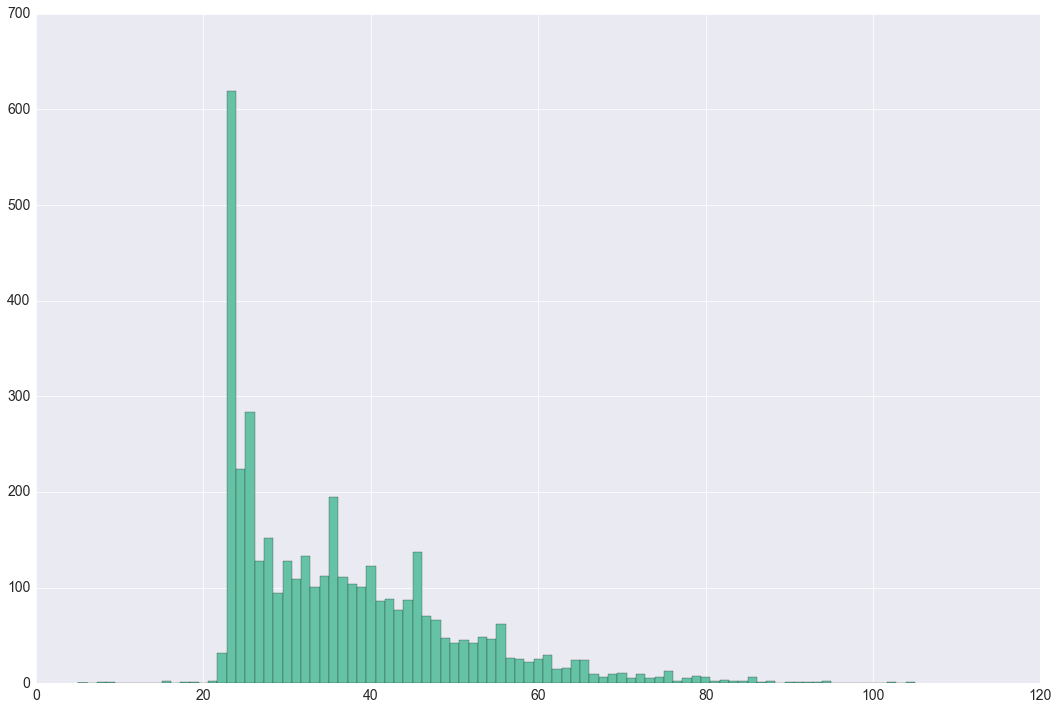

In [36]:
# plotting the histogram
plt.figure(figsize=(18,12))
X_train['var15'].hist(bins=90);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

From the histogram, the importance variables, var15, could have an approximated gaussian distribution with a mean value = 34 and a standard deviation of 13 and looks like to a distribution of  the age of the customers.

In [37]:
#Predict Output using the test set
predicted_rf =  clf_forest.predict(X_test)                           

#Confusion matrix for the prediction 
cf_test_rf = mt.confusion_matrix(y_test.ravel(), predicted_rf)
print 'Confusion Matrix'
print cf_test_rf
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_rf))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_rf))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_rf))

Confusion Matrix
[[758 260]
 [249 719]]
Precision = 0.7344
Recall = 0.7428
Accuracy = 0.7437


As we aspect, the accuracy of the random forest model increases respect to decision trees. 

### Gradient Boosting
<a id='grad'></a>

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [38]:
#Gradient Boosting object and fitted the model
clf_GradBoost = GradientBoostingClassifier(n_estimators=500, subsample=0.3, 
                                           learning_rate=0.1,
                                           max_depth=1, 
                                           random_state=0).fit(X_train, y_train.ravel()) 

In [39]:
#feature importancefor Gradient Boosting
importances_gbm = clf_GradBoost.feature_importances_ 
indices_gbm = np.argsort(importances_gbm)[::-1]

# Print the feature ranking: look at this and make the first interpretation

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices_gbm[f], importances_gbm[indices_gbm[f]]))

Feature ranking:
1. feature 102 (0.144000)
2. feature 0 (0.116000)
3. feature 60 (0.070000)
4. feature 1 (0.038000)
5. feature 96 (0.030000)
6. feature 56 (0.028000)
7. feature 94 (0.028000)
8. feature 75 (0.026000)
9. feature 97 (0.026000)
10. feature 95 (0.026000)
11. feature 5 (0.022000)
12. feature 6 (0.022000)
13. feature 91 (0.022000)
14. feature 64 (0.020000)
15. feature 90 (0.016000)
16. feature 98 (0.016000)
17. feature 76 (0.016000)
18. feature 8 (0.016000)
19. feature 61 (0.016000)
20. feature 65 (0.014000)
21. feature 93 (0.014000)
22. feature 45 (0.014000)
23. feature 2 (0.014000)
24. feature 86 (0.014000)
25. feature 40 (0.014000)
26. feature 74 (0.014000)
27. feature 92 (0.012000)
28. feature 7 (0.012000)
29. feature 88 (0.012000)
30. feature 99 (0.010000)
31. feature 4 (0.010000)
32. feature 62 (0.008000)
33. feature 44 (0.008000)
34. feature 89 (0.008000)
35. feature 73 (0.008000)
36. feature 42 (0.006000)
37. feature 83 (0.006000)
38. feature 48 (0.006000)
39. feature

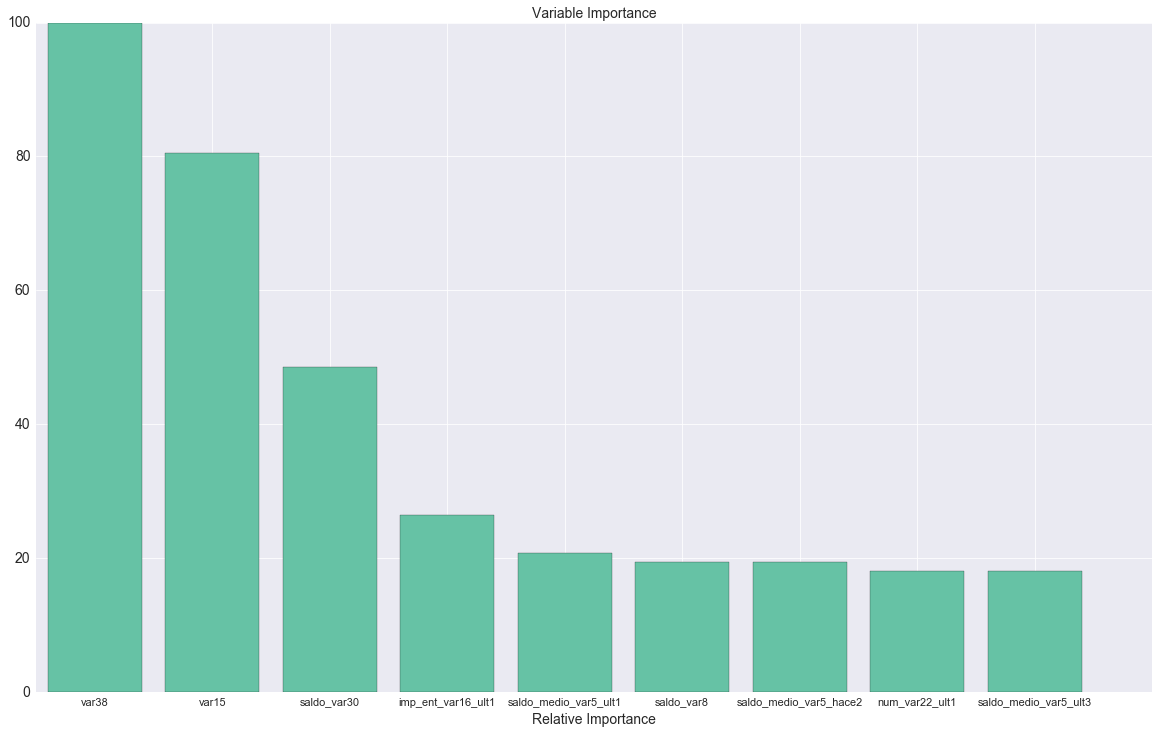

In [40]:
# make importances relative to max importance

feature_importance_gbm = 100.0 *(importances_gbm / importances_gbm.max())

sorted_idx = np.argsort(feature_importance_gbm)[:93:-1]


labels = []
for l in data.columns[sorted_idx]:
    labels.append(l)
pos = np.arange(sorted_idx.shape[0]) 
plt.figure(figsize=(20,12))
plt.bar(pos, feature_importance_gbm[sorted_idx], align='center')
plt.yticks(fontsize=14)
plt.xticks(range(sorted_idx.shape[0]),labels, fontsize=11)
plt.xlabel('Relative Importance', fontsize=14)
plt.title('Variable Importance', fontsize=14)
plt.xlim([-0.5, sorted_idx.shape[0]])
plt.show()

As Random Forest, we assess the variable importances and find the same first two variables: var38 and var15.

In [41]:
#Predict Output using the test set
predicted_gbm = clf_GradBoost.predict(X_test)                 

#Confusion matrix for the prediction 
cf_test_gbm = mt.confusion_matrix(y_test, predicted_gbm)
print 'Confusion Matrix'
print cf_test_gbm
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_gbm))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_gbm))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_gbm))

Confusion Matrix
[[784 234]
 [264 704]]
Precision = 0.7505
Recall = 0.7273
Accuracy = 0.7492


As we aspect, the accuracy of the Gradient Boosting model increases respect to the random forest. Indeed:
- Boosting is based on weak learners (high bias, low variance) as all tree-based models. 
In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).
- Random Forest uses as you said fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). 

### Extreme Gradient Boosting
<a id='ext'></a>

XG Boosting is an efficient implementation of gradient boosting framework. 
The current implementation of the Gradient Boosting Machine is not fast enough so that we may need to wait for a long time for the result and XGBoosting was born to speed this form of model [3]. 


In [42]:
## Build a XgBoosting object
clf_xgb = xgb.XGBClassifier(max_depth = 5,
                            n_estimators=500,
                            learning_rate=0.01,
                            nthread=6,
                            subsample=0.95,
                            colsample_bytree=0.90,
                            seed=4241)
classifier_xgb = clf_xgb.fit(X_train, y_train.ravel())

#Predict Output using the test set
predicted_xgb = clf_xgb.predict(X_test)  

#Confusion matrix for the prediction 
cf_test_xgb = mt.confusion_matrix(y_test.ravel(), predicted_xgb)
print 'Confusion Matrix'
print cf_test_xgb
print ('Precision = %0.4f' % mt.precision_score(y_test, predicted_xgb))
print ('Recall = %0.4f' % mt.recall_score(y_test, predicted_xgb))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_test, predicted_xgb))

Confusion Matrix
[[789 229]
 [247 721]]
Precision = 0.7589
Recall = 0.7448
Accuracy = 0.7603


The resulting confusion matrix of Extreme Gradient Boosting gives us the best result of all model until now.

### Support Vector Machine
<a id='svm'></a>

Support vector machines are supervised learning models with associated learning algorithms. Given a set of training, each marked for belonging to one of two categories, an SVM training algorithm builds a model that assigns new data into one category or the other, making it a non-probabilistic binary linear classifier. 
In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces [4,5]. <br>

In [52]:
# Normalize dataset before 
data_pca = preprocessing.normalize(data)

In [53]:
# Perform an eigendecomposition on the covariance matrix
cor_mat = np.corrcoef(data_pca.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat)

In [55]:
#Explained Variance
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

- The explained variance tells us how much information (variance) can be attributed to each of the principal components. We take the first 6 components that explain the 73% of variance.

In [56]:
#Perform a principal component analysis 
X_pca = TruncatedSVD(n_components=6).fit_transform(data_pca)

#Build a principal component analysis
X_trainpca, X_testpca, y_trainpca, y_testpca = train_test_split(X_pca, t, 
                                                    test_size=0.33, random_state=50)

We apply the linear kernel because is good when there is a lot of features. That's because mapping the data to a higher dimensional space does not really improve the performance. 

In [57]:
## Build a Support vector machine object
clf_SVM_kernel = svm.SVC(probability=True, cache_size=1000, kernel='linear', C=1, gamma=1)
classifier_SVM_kernel = clf_SVM_kernel.fit(X_trainpca, y_trainpca.ravel())

#Predict Output using the test set
predicted_svm = classifier_SVM_kernel.predict(X_testpca)

#Confusion matrix for the prediction 
cf_test = mt.confusion_matrix(y_testpca, predicted_svm)
print 'Confusion Matrix'
print cf_test
print ('Precision = %0.4f' % mt.precision_score(y_testpca, predicted_svm))
print ('Recall = %0.4f' % mt.recall_score(y_testpca, predicted_svm))
print ('Accuracy = %0.4f' % mt.accuracy_score(y_testpca, predicted_svm))

Confusion Matrix
[[117 901]
 [ 26 942]]
Precision = 0.5111
Recall = 0.9731
Accuracy = 0.5332


Despite of dimensionality reduction with PCA, the Support Vector Machine doesn't performe better than others tecniques shown up to now.

# Conclusions
<a id='conc'></a>
             
Here, we compare the Receiver Operating Characteristic (ROC) curves of all methods before discussed, in order to assess the best classifier for our analysis.


In [48]:
# Learn to predict each class against the other (for test sample)

y_prob_lg = classifier_lg.predict_proba(X_test)
y_prob_rf = classifier_rf.predict_proba(X_test)
y_prob_tr = classifier_tr.predict_proba(X_test)
y_prob_gbm = clf_GradBoost.predict_proba(X_test)
y_prob_adaB = classifier_adaB.predict_proba(X_test)
y_prob_xgb = classifier_xgb.predict_proba(X_test)
y_prob_bg = classifier_bg.predict_proba(X_test)
y_prob_SVM= classifier_SVM_kernel.predict_proba(X_testpca)

In [49]:
# define the roc curse parameters
fpr_lg, tpr_lg, thresholds_lg = roc_curve(np.array(y_test), y_prob_lg[:,1], pos_label=1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.array(y_test), y_prob_rf[:,1], pos_label=1)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(np.array(y_test), y_prob_tr[:,1], pos_label=1)
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(np.array(y_test), y_prob_gbm[:,1], pos_label=1)
fpr_adaB, tpr_adaB, thresholds_adaB = roc_curve(np.array(y_test), y_prob_adaB[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(np.array(y_test), y_prob_xgb[:,1], pos_label=1)
fpr_bg, tpr_bg, thresholds_bg = roc_curve(np.array(y_test), y_prob_bg[:,1], pos_label=1)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(np.array(y_testpca), y_prob_SVM[:,1], pos_label=1)

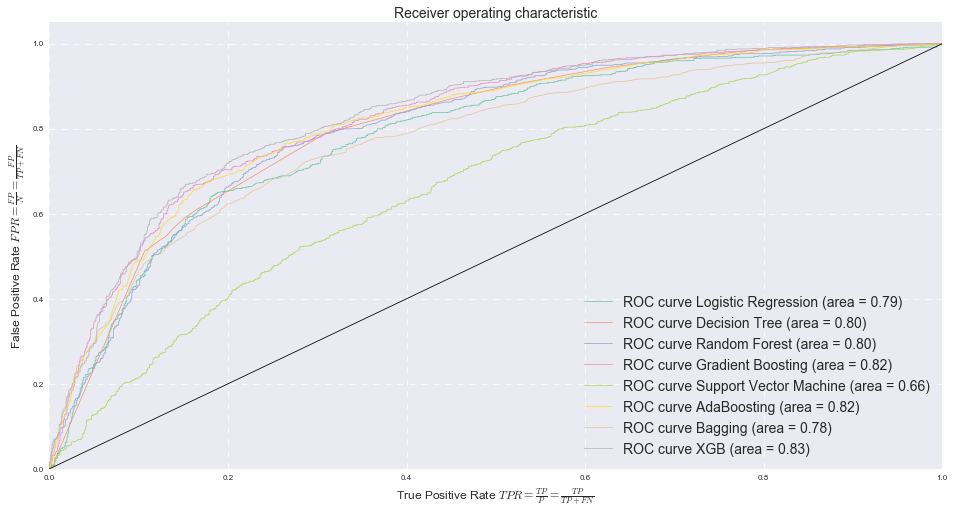

In [50]:
# plot the roc curves
plt.figure(figsize=(16,8), dpi=1600)
plt.plot(fpr_lg, tpr_lg, color=colors[0],label='ROC curve Logistic Regression (area = %0.2f)' %  auc(fpr_lg, tpr_lg))
plt.plot(fpr_tr, tpr_tr, color=colors[1],label='ROC curve Decision Tree (area = %0.2f)' %  auc(fpr_tr, tpr_tr))
plt.plot(fpr_rf, tpr_rf, color=colors[2],label='ROC curve Random Forest (area = %0.2f)' %  auc(fpr_rf, tpr_rf))
plt.plot(fpr_gbm, tpr_gbm, color=colors[3],label='ROC curve Gradient Boosting (area = %0.2f)' %  auc(fpr_gbm, tpr_gbm))
plt.plot(fpr_SVM, tpr_SVM, color=colors[4],label='ROC curve Support Vector Machine (area = %0.2f)' %  auc(fpr_SVM, tpr_SVM))
plt.plot(fpr_adaB, tpr_adaB, color=colors[5],label='ROC curve AdaBoosting (area = %0.2f)' %  auc(fpr_adaB, tpr_adaB))
plt.plot(fpr_bg, tpr_bg, color=colors[6],label='ROC curve Bagging (area = %0.2f)' %  auc(fpr_bg, tpr_bg))
plt.plot(fpr_xgb, tpr_xgb, color=colors[7],label='ROC curve XGB (area = %0.2f)' %  auc(fpr_xgb, tpr_xgb))

plt.plot([0, 1], [0, 1],'k-', linewidth=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel(r'True Positive Rate $TPR=\frac{TP}{P}=\frac{TP}{TP+FN}$', fontsize=12)
plt.ylabel(r'False Positive Rate $FPR=\frac{FP}{N}=\frac{FP}{TP+FN}$', fontsize=12)
plt.title('Receiver operating characteristic', fontsize=14)
plt.grid(color='white', linestyle='dashed')
plt.legend(loc="lower right", fontsize=14)
plt.show()



We noticed that the Logistic Regression and the Support Vector Machine are less performing then tree-based models. Then, if we apply

In conclusion, the best classifier among the considered ones is the Extreme Gradient Boosting, yielding an AUC value of 0.83.

In [59]:
# Area under curve
print ('AUC LG = %0.3f' % auc(fpr_lg, tpr_lg))
print ('AUC DT = %0.3f' % auc(fpr_tr, tpr_tr))
print ('AUC RF = %0.3f' % auc(fpr_rf, tpr_rf))
print ('AUC GBM = %0.3f' % auc(fpr_gbm, tpr_gbm))
print ('AUC AdaBoosting = %0.3f' % auc(fpr_adaB, tpr_adaB))
print ('AUC Bagging = %0.3f' % auc(fpr_bg, tpr_bg))
print ('AUC SVM = %0.3f' % auc(fpr_SVM, tpr_SVM))
print ('AUC XGB = %0.3f' % auc(fpr_xgb , tpr_xgb))

AUC LG = 0.788
AUC DT = 0.804
AUC RF = 0.803
AUC GBM = 0.825
AUC AdaBoosting = 0.815
AUC Bagging = 0.778
AUC SVM = 0.663
AUC XGB = 0.831


In this notebook, we have considered for our analysis the cleaning data performed in Section 1. Then we performed the same analysis using the full dataset, in order to understand better which information we loose from our cleaning. The following table shows the comparing between the two set of data according to the Area under Curve, calculated for each techniques. In our opinion, the cleaning operation was done with a well approximation and in some cases, improve the goodness of fit.  

In [60]:
#loading AUCs from the full dataset (cleaning off)

# aucs-full = load(auc_vect)

| Model | AUC | AUC-Full         
| :- |-------------: | :-:
|Logistic Regression|  0.79| 0.79
| Decision Tree |  0.80| 0.80
| Random Forest |  0.80| 0.80
|Gradient Boost.|  0.83| 0.83
| AdaBoost      | 0.82 | 0.81
| Bagging       | 0.78 | 0.79
| SVM           | 0.66 | 0.62
|  XGB          | 0.83 | 0.83

## 5. References
<a id='ref'></a>

\[1\] Scikit Library (http://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  

\[2\] Ensemble Methods (http://scikit-learn.org/stable/modules/ensemble.html)  

\[3\] Extreme Gradient Boosting (http://xgboost.readthedocs.io/en/latest/model.html)  

\[4\] Support Vector Machine. (http://www.support-vector-machines.org)

\[5\] The elements of statistical learning. Trevor Hastie,Robert Tibshirani and Jerome Friedman [Springer]